## Pix2pix image colorization. 
#### Examples using pre-trained generator model and a collection of images that are in the training and outside the training set. Also getting results analyzed via histogram comparsions and attempting to colorize webcam mjpeg stream in real time.

https://github.com/skirdey/mxnet-pix2pix - code to train pix2pix using MXNet and Python 3.6, it also visualizes training process via cv2 library

The network was trained on a set of 36000 256x256 images mostly covering city streets and city scape. The images were extracted from a video at about 4fps. The training process took approximately 20 hours on a laptop with Nvidia Geforce GTX 1060 with 6GB of video memory. 

Skinny of the tutorial:
1. Load an image
2. Convert to lab and extract lightness
3. Run lightness through pre-trained pix2pix generator
4. Display and analyize colorization result
5. Colorize video captchured from a live web-cam in real-time and display an example. 

#### Demo of real-time colorization ( not real time anymore ). Video stream came from a web camera attached to the computer. 
https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization_street.gif

In [1]:
from IPython.display import HTML
HTML('<img src="https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization_street.gif">')

#### Demo of real-time colorization ( not real time anymore ). Video stream came from an online web camera.
https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization.gif

In [2]:
from IPython.display import HTML
HTML('<img src="https://s3-us-west-1.amazonaws.com/pix2pix/real_time_video_colorization.gif">')

#### Let's start!

In [3]:
%matplotlib inline
import logging
import os
import glob
import cv2
import time
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import gluon
from mxnet import autograd
import numpy as np
from datetime import datetime
import PIL
from PIL import Image
from zope.interface import implementer

import matplotlib
import matplotlib.pyplot as plt

from cv2_utils import show_mxnet_to_numpy_array, show_numpy_array
from util import rgb_to_lab
from util.process_lab_utils_mx import preprocess_lab
from util.process_lab_utils_np import lab_parts_to_rgb

from network.gluon_pix2pix_modules import UnetGenerator, Discriminator
from report.Metric import Metric
from util.process_lab_utils_np import lab_parts_to_rgb
from util.visual_utils import visualize_cv2
from network.neural_network_interface import NeuralNetworkInterface
from util.lab_color_utils_mx import rgb_to_lab

Importing necessary utilities and system modules. We are doing lab colorization, meaning we will convert an image into the lab space and use the lightness channel to run it through a generator. The network, traning, and helper classed can be found here - https://github.com/skirdey/mxnet-pix2pix

In [4]:
ctx = mx.cpu(0)

#### Helper functions
What we are doing here is loading a pre-trained generator model, and binding data parameters to it.
We also have several functions to load an image, either jpeg or png, and get is lightness channel that we can run through generator network. 

In [5]:
def timeme(method):
    def wrapper(*args, **kw):
        startTime = time.time()
        result = method(*args, **kw)
        endTime = time.time()
        print(str(method.__name__) + ": ", endTime - startTime , 'seconds')
        return result
    return wrapper

In [6]:
def load_generator_from_checkpoint(position):
    filename_net_g = "netG{}".format(position)
    net_g = UnetGenerator(in_channels=1, num_downs=8, final_out=2) # 2 channels, a and b - for colorization
    assert net_g
    net_g.load_params(filename_net_g, ctx=ctx)
    assert net_g
    net_g.hybridize()
    return net_g

In [7]:
 def prepare_real_in(batch):
    real_a = batch.data[0]
    lab = rgb_to_lab(real_a, ctx=ctx)
    lightness_chan, a_chan, b_chan = preprocess_lab(lab)
    real_in = nd.expand_dims(lightness_chan, axis=2)
    real_in = real_in.transpose((3, 2, 0, 1))
    return real_in

In [8]:
def load_image(image_filename):
    assert image_filename
    with open(image_filename, 'rb') as fp:
        str_image = fp.read()

    return mx.img.imdecode(str_image)

##### Note
Get color channels function uses internal helper functions to process an RGB image into LAB space. 
It also resizes an image into 256 by 256 square so we can run it through the generator network. 
Before returning the result, we resize the generator's output back to image's original size. 
As generator expects a square image, it is best to operate on square sample images to test out colorization. 

In [9]:
@timeme
def generator_run(model, image):
    return model(prepare_real_in(mx.io.DataBatch([image]))) # ugly, but allows for code re-use

In [10]:
def get_real_A(real_in):
    real_a = real_in
    real_a = nd.cast(real_a, "uint8")

    real_a = real_a.transpose((0, 2, 3, 1))
    real_a = nd.array(np.squeeze(real_a.asnumpy(), axis=0), ctx=self.ctx)
    lab = rgb_to_lab(real_a, ctx=self.ctx)
    lightness_chan, a_chan, b_chan = preprocess_lab(lab)

    real_in = nd.expand_dims(lightness_chan, axis=2)
    real_in = real_in.transpose((3, 2, 0, 1))

In [11]:
def get_color_channels(image, model):
    w, h = image.shape[0:2]

    if image.shape[0:2] != (256, 256):
        image = mx.image.resize_short(image, 256)
        image = mx.image.center_crop(image, (256, 256))[0]

    output = generator_run(model, image)
    
    a_b_channels = squeeze_mx_image(output).transpose((2,1,0))

    a_b_channels = cv2.resize(a_b_channels.asnumpy(), (w, h))
    a_b_channels = nd.expand_dims(nd.array(a_b_channels), axis=2).transpose((2, 3, 1, 0))
    return a_b_channels

In [12]:
def squeeze_mx_image(image):
    return nd.array(np.squeeze(image.asnumpy(), axis=0), ctx=ctx)

In [13]:
def get_lightness(image):
    image = image.as_in_context(ctx)
    lab = rgb_to_lab(image, ctx=ctx)
    lightness_chan, _, _ = preprocess_lab(lab)
    return lightness_chan

In [14]:
def colorize_image(real_a, model):
    real_a = nd.cast(real_a, "uint8")
    color_channels = get_color_channels(real_a, model)
    original_size_lightness = get_lightness(real_a)

    grayscale_lightness = nd.expand_dims(original_size_lightness, axis=2).transpose((3,2,0,1))

    fake_rgb = lab_parts_to_rgb(color_channels.asnumpy() * 1, grayscale_lightness.asnumpy(), ctx)
    
    return fake_rgb

#### Moment of truth
Let's load an image that I've taken on my phone, cropped it to a square and resized to 512x512. The neural net never seen this picture before. It was quite new for me as well - sunny in Seattle!

#### A bit on Pix2pix
Pix2pix approach is based on two neural networks, that are trained at the same time. 

Generator network in a original GAN is a model that learns mapping from random noise vector $z$ to output image $y$:

$$G : z \rightarrow y$$

Pix2pix uses approach of conditional GANS, where generator learns mapping from original image $x$ and random noise vector $z$ to original image $y$:

$$ G : {x, z} \rightarrow y$$

The objective of a pix2pix training is $G^{∗}= arg\,\underset{G}{min}\,\underset{D}{max}\,\mathcal{L}_{cGAN} (G, D) \,+\, \alpha\times \mathcal{L}_{L1}(G)$

The objective stands for use gradient 'ascent' on Discriminator and *increase* the probability of detecting fakes and recognizes real pictures, and use gradient descent on the generator to decrease the probability to be detected as a fake. 

In [15]:
model = load_generator_from_checkpoint(100)
real = load_image("./test_img/flo_1.jpg")
colorized =  colorize_image(real, model)

generator_run:  0.013531208038330078 seconds


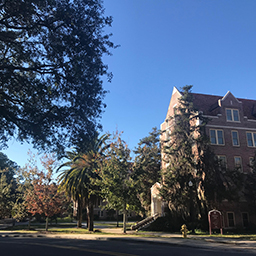

In [16]:
# Original, straight from the phone
real = real.asnumpy() # It has type MXNet.NDArray at this point
Image.fromarray(real)

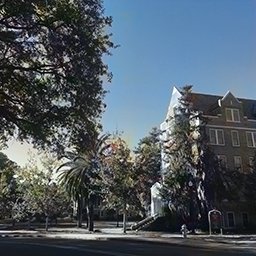

In [17]:
# Colorized version
Image.fromarray(colorized)

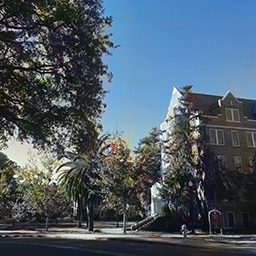

In [18]:
from PIL import ImageEnhance
enhancer = ImageEnhance.Color(Image.fromarray(colorized))
enhancer.enhance(1.3)

#### Metrics
It is nice to see the result visually. And it is nice to see some quanitifed metrics. We can have rgb histogram comparsions between original and colorized version, and also an L1 difference between the fake and the real images. It also make sense to time the colorization call itself, and see how fast it performs its task. Lets start with it:

#### Histograms

/Users/stan/anaconda3/envs/deeply/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


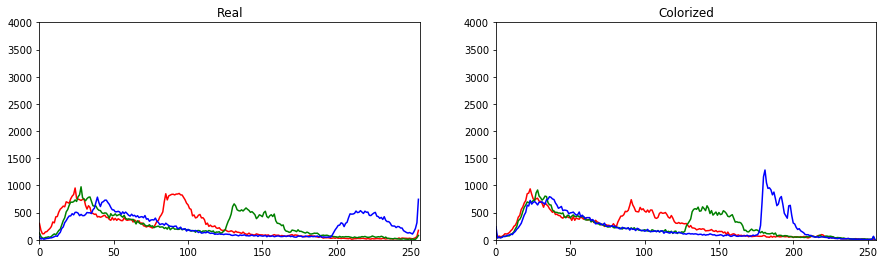

In [19]:
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red')
green_patch = mpatches.Patch(color='green')
blue_patch = mpatches.Patch(color='blue')

color = ('r','g','b')
plt.figure(figsize=(15,4))
for channel, col in enumerate(color):
    histr_real = cv2.calcHist([real], [channel], None, [256], [0,256])
    histr_colorized = cv2.calcHist([colorized], [channel], None, [256], [0,256])
    
    plt.xlim([0,256])
    plt.ylim([0,4000])
    plt.subplot(1, 2, 1) # plt.subplot allows us to plot side by side, the args are (row, col, current plot)
    plt.title("Real")
    plt.plot(histr_real,color = col)
    
    plt.xlim([0,256])
    plt.ylim([0,4000])
    plt.subplot(1,2,2)
    plt.title("Colorized")
    plt.plot(histr_colorized, color = col)
    

plt.show()

Just for the test, lets make sure the histogram of real image has correlation of 1 
to itself, and do the same for the colorized version 

Let's compute the difference numerically using OpenCV compareHist function. 
https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=comparehist#comparehist

In [20]:
# Comparing all three color channels at once
histr_real = cv2.calcHist([real], [0,1,2], None, [256, 256, 256], [0,256, 0, 256, 0, 256])
histr_colorized = cv2.calcHist([colorized], [0,1,2], None, [256, 256, 256], [0,256, 0, 256, 0, 256])


cv2.compareHist(histr_real, histr_real, 0)

In [21]:
cv2.compareHist(histr_colorized, histr_colorized, 0)

1.0

At least we know that correlation functions works on two identical histograms. 
Lets try it on real and colorized images. Correlatiom method performs following computation:

### Correlation metric
[-1:1], 1 being perfect match

$$d(H_1,H_2) =  \frac{\sum_I (H_1(I) - \bar{H_1}) (H_2(I) - \bar{H_2})}{\sqrt{\sum_I(H_1(I) - \bar{H_1})^2 \sum_I(H_2(I) - \bar{H_2})^2}}$$ where $$\bar{H_k} =  \frac{1}{N} \sum _J H_k(J)$$ and $N$ is a total number of bins. 

In [22]:
cv2.compareHist(histr_real, histr_colorized, 0)

-0.02736799249868916

-0.27 - Not great, but not bad. The colorized image looks like a badly taken photo, but the colors there do make sense.

### Chi-Square
[0: positive infinity], 0 is perfect match
It computes $$d(H_1,H_2) =  \sum _I  \frac{\left(H_1(I)-H_2(I)\right)^2}{H_1(I)}$$

In [23]:
cv2.compareHist(histr_real, histr_colorized, 1)

63722.40587325939

### Bhattacharyya distance
[-1: 1], 0 is perect match
$$d(H_1,H_2) =  \sqrt{1 - \frac{1}{\sqrt{\bar{H_1} \bar{H_2} N^2}} \sum_I \sqrt{H_1(I) \cdot H_2(I)}}$$

In [24]:
cv2.compareHist(histr_real, histr_colorized, 3)

0.9341067829055937

0.8798752374385485 - far away from a perfect match. Still, visually colorization result doesn't feel that wrong. 

### Video colorization on the client in a browser

In [25]:
%matplotlib notebook
import signal

In [29]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [30]:
one_more_url = "http://217.197.157.7:7070/axis-cgi/mjpg/video.cgi?resolution=320x240"
url = "http://85.46.64.147/axis-cgi/mjpg/video.cgi?camera=&resolution=320x240" # looks like italy
vc = cv2.VideoCapture('http://im5.ezgif.com/tmp/ezgif-5-4acd15ab79.mp4')

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    frame_colorized = colorize_image(nd.array(frame), model)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    webcam_preview_original = plt.imshow(frame)
    plt.subplot(1, 2, 2)
    webcam_preview_colorized = plt.imshow(frame_colorized)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read() 
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    frame_colorized = colorize_image(nd.array(frame), model)
    
    webcam_preview_original.set_data(frame)
    webcam_preview_colorized.set_data(frame_colorized)
    
    plt.show()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break

# Let's process a sample video file

In [31]:
# Define the codec and create VideoWriter object
import time
import signal
input_video = "./video_examples/seattle.mp4"
output = "./video_examples/seattle_colorized.mp4"
width = 256
height = 256
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter(output, fourcc, 24, (width, height))

In [32]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [ ]:
cap = cv2.VideoCapture(input_video)

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False

while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is not None and frame.shape == (256, 256, 3):
#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_colorized = colorize_image(nd.cast(nd.array(frame), "uint8"), model)
        frame_colorized = cv2.cvtColor(frame_colorized, cv2.COLOR_BGR2RGB)
        cv2.imshow("fake", frame_colorized)
        out.write(frame_colorized)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    if is_interrupted:
        cap.release()
        out.release()
        break
cap.release()
out.release()

cv2.destroyAllWindows()